<a href="https://colab.research.google.com/github/ngcheeyuan/Fraud_Detection_Capstone/blob/main/Capstone_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#outlier detection
from sklearn.svm import OneClassSVM

In [2]:
df_0 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/young_adults_female_urban.csv', sep ='|')
df_1 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/young_adults_male_urban.csv', sep ='|')
df_2 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/adults_2550_male_urban.csv', sep ='|')
df_3 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/adults_2550_female_urban.csv', sep ='|')
df_4 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/adults_50up_male_urban.csv', sep ='|')
df_5 = pd.read_csv('/content/drive/MyDrive/Capstone Dataset/adults_50up_female_urban.csv', sep ='|')

In [3]:
df = pd.concat([df_0,df_1,df_2,df_3,df_4,df_5])

In [4]:
df['trans_date_time'] = df['trans_date'] + " " + df['trans_time']
df.loc[:,'trans_date_time'] = pd.to_datetime(df['trans_date_time'])

In [5]:
#df['trans_date_time'].dtype

In [6]:
df.loc[:,'dob'] = pd.to_datetime(df['dob'],format= '%Y-%m-%d')

In [7]:
df.sort_values(by = 'trans_date_time', ascending = True , inplace = True)
df.set_index('trans_date_time', inplace = True)

In [8]:
#creating basic date related features
df['trans_year'] = df.index.year
df['trans_month'] = df.index.month
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df.loc[:,'weekday'] =  df['weekday'] + 1
df['day'] = df.index.day

In [9]:
check_dup = df.groupby('cc_num').agg({'first':np.count_nonzero,'acct_num':np.count_nonzero})
check_dup['check'] =check_dup['first'] - check_dup['acct_num']
check_dup['check'].value_counts() # no duplicated accounts.

0    514
Name: check, dtype: int64

In [10]:
df.loc[df['trans_num'].duplicated()] # no duplicated transactions

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_year,trans_month,weekday,hour,day
trans_date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [11]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
df['dob'] = pd.to_datetime(df['dob'])
df['age_at_trans'] = df['trans_date'] - df['dob']
df.loc[:,'age_at_trans']=df['age_at_trans'].map(lambda x : x.days)
df.loc[:,'age_at_trans'] = np.round(df['age_at_trans']/365.25)

In [12]:
df.loc[df['age_at_trans']<18]
#card holders are all above 18, at time of transaction.

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num,profile,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,trans_year,trans_month,weekday,hour,day,age_at_trans
trans_date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [13]:
df.loc[:,'merchant'] = df['merchant'].map(lambda x : x.replace('fraud_',''))

In [14]:
df['name'] = df['first'] + ' ' + df['last']
df['gender'] = df['gender'].map(lambda x : 1 if x == 'M' else 0) #changing object to numeric datatype

In [15]:
df['cc_num'].unique().shape,df['acct_num'].unique().shape,df['ssn'].unique().shape #seems like these are all unique idenitfiers for the different credit ca

((514,), (514,), (514,))

In [16]:
df.drop(columns = ['profile','first','last','street','zip','ssn','acct_num','trans_time'] , inplace = True)

## Train test split prior to EDA

In [17]:
df.loc['2012-01-01':'2014-12-31'].to_csv('train_ts.csv')
df.loc['2015-01-01':'2015-12-31'].to_csv('test_ts.csv')

In [18]:
#from google.colab import files
#files.download("train_ts.csv")
#files.download("test_ts.csv")

## EDA

In [19]:
df = pd.read_csv('train_ts.csv')

In [20]:
df.loc[:,'trans_date_time'] = pd.to_datetime(df['trans_date_time'])
df.loc[:,'trans_date'] = pd.to_datetime(df['trans_date'])
df.set_index('trans_date_time', inplace = True)

In [21]:
df.memory_usage().sum()/1_000_000

287.651104

In [22]:
def down_cast(df_):
  #cat_columns = ['cc_num','state','merchant','job','category','name']
  #df_[cat_columns] = df_[cat_columns].astype('category')
  unsigned_int = ['city_pop','unix_time','gender','is_fraud','weekday','hour','day','age_at_trans','trans_year','trans_month']
  df_[unsigned_int] = df_[unsigned_int].apply(pd.to_numeric, downcast='unsigned')
  fcols = df.select_dtypes('float').columns
  df_[fcols] = df_[fcols].apply(pd.to_numeric, downcast='float')

  return df_

In [23]:
df = down_cast(df)

In [24]:
df.memory_usage().sum()/1_000_000

172.86725

In [25]:
df['is_fraud'].mean(), 1 - df['is_fraud'].mean()

(0.0027080028171906478, 0.9972919971828094)

We have a severely imbalanced data set on our hands, where only 0.27% of all transactions are fraudulent. 

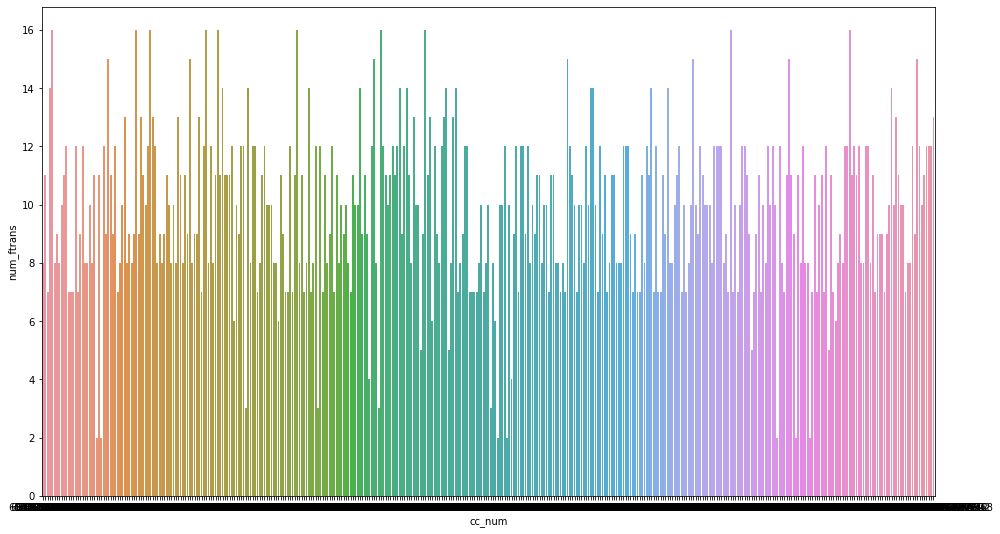

In [26]:
mask = df['is_fraud'] == 1
f_exp = df[mask].groupby('cc_num').agg({'is_fraud':np.sum}).rename(columns = {'is_fraud':'num_ftrans'}).reset_index()
plt.figure(figsize = (16,9))
sns.barplot(data = f_exp, x = 'cc_num', y = 'num_ftrans') #

In [27]:
f_exp['num_ftrans'].value_counts()

12    65
8     63
11    53
7     50
10    48
9     40
14    14
13    11
16    10
15     7
2      7
6      5
5      4
3      4
4      2
Name: num_ftrans, dtype: int64

Fraudulent transactions with the same card tends to happen more than once. 

No clear visual difference between fraudulent acitivity and age of card holder when transaction occured.

In [28]:
def age_bin(df_):
  x = df_['age_at_trans']
  condlist = [x<=age for age in np.arange(20,110,10)]
  choicelist = [bin for bin in np.arange(20,110,10)]
  df_['age_bin'] = np.select(condlist,choicelist)

  return df_

In [29]:
df = age_bin(df)

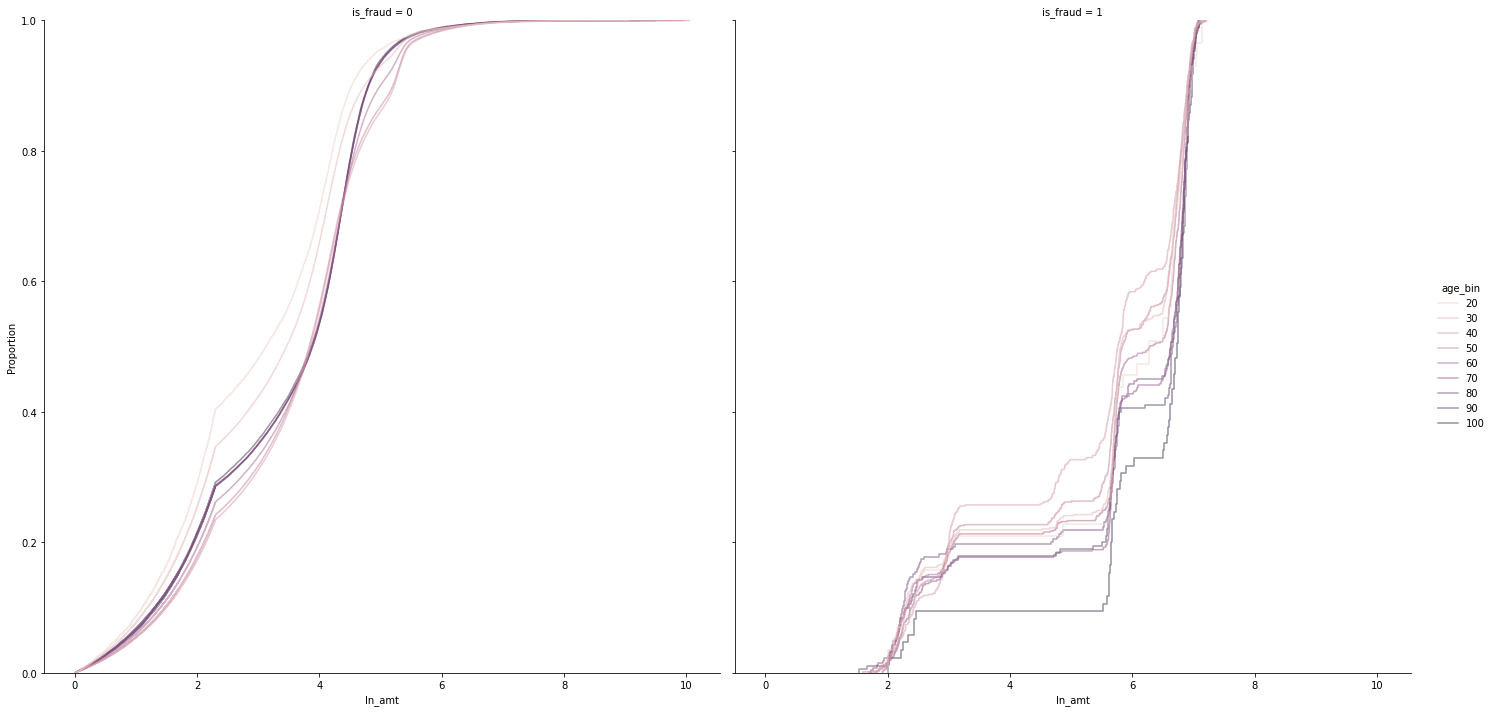

In [30]:
df['ln_amt'] = np.log(df['amt'])
sns.displot(data = df.reset_index() , 
            x = 'ln_amt' ,
            hue = 'age_bin',
            col = 'is_fraud',
            alpha = 0.5 , 
            height = 10,
            aspect = 1,
            kind = 'ecdf' ) 

In [31]:
df.groupby('age_bin').agg({'is_fraud':[np.mean,np.std],
                          'amt':[np.min,np.max,np.mean,np.median,np.std,np.count_nonzero]})

is_fraud            amt  ...                                     
             mean       std amin  ...     median         std count_nonzero
age_bin                           ...                                     
20       0.005131  0.071453  1.0  ...  23.005001  177.505804       11108.0
30       0.002534  0.050279  1.0  ...  31.940001  176.409590      253705.0
40       0.001805  0.042445  1.0  ...  47.009998  156.870334      335762.0
50       0.002045  0.045175  1.0  ...  46.160000  155.777787      337901.0
60       0.003541  0.059400  1.0  ...  48.009998  150.091971      194870.0
70       0.004572  0.067460  1.0  ...  48.980000  160.025546      113523.0
80       0.003920  0.062487  1.0  ...  48.730000  133.145789       67349.0
90       0.004656  0.068080  1.0  ...  47.974998  179.353878       40804.0
100      0.003045  0.055097  1.0  ...  48.845001  150.482757       27916.0

[9 rows x 8 columns]

In [32]:
temp_df1 = df['age_bin'].value_counts().reset_index().rename(columns={'index':'age_bin','age_bin':'num_of_trans'})
mask = df['is_fraud']==1
temp_df2 = df[mask]['age_bin'].value_counts().reset_index().rename(columns={'index':'age_bin','age_bin':'num_of_trans'})

In [33]:
age_exp = temp_df1.merge(temp_df2,how = 'left', on = 'age_bin')
age_exp['proportion_fraud'] = age_exp['num_of_trans_y']/age_exp['num_of_trans_x']

Text(0.5, 1.0, 'Fraudulent transactions')

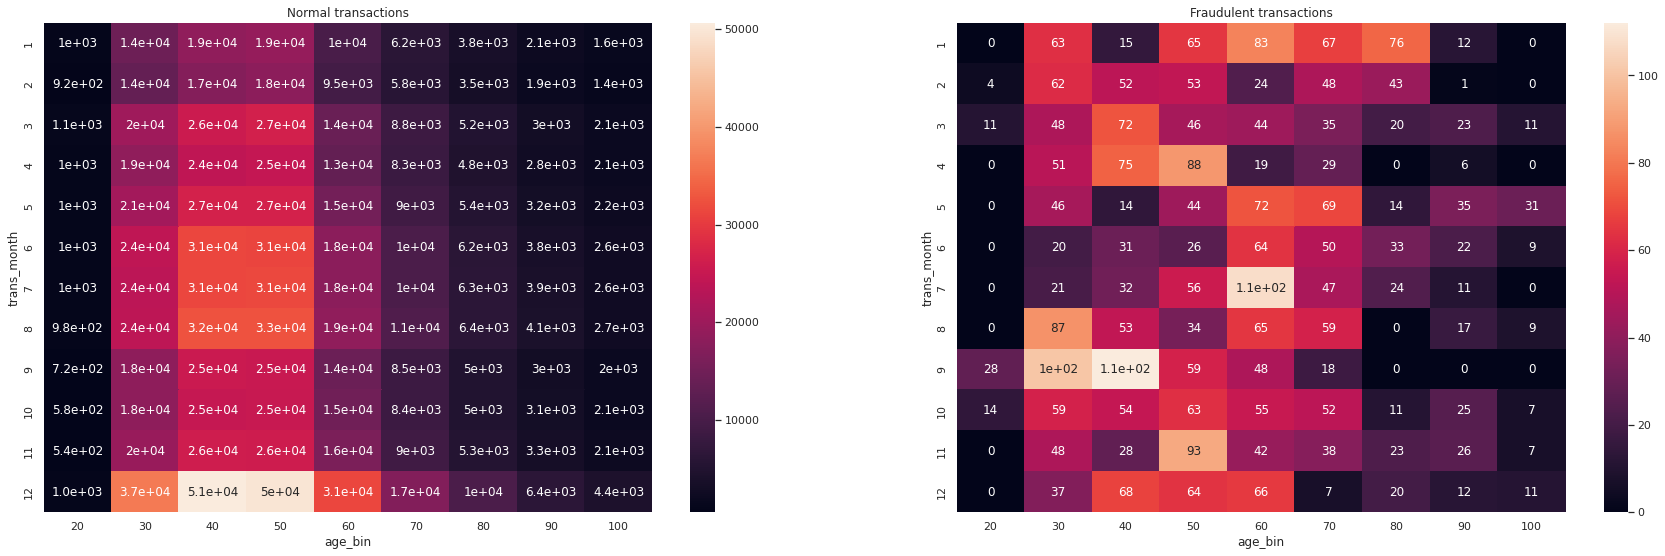

In [98]:
fig,ax = plt.subplots(1,2,figsize = (30,9))
mask = df.is_fraud == 0
sns.heatmap(pd.crosstab(df[mask].trans_month,df[mask].age_bin) , ax = ax[0], annot = True)
ax[0].set_title('Normal transactions')
mask = df.is_fraud == 1
sns.heatmap(pd.crosstab(df[mask].trans_month,df[mask].age_bin) , ax = ax[1] , annot = True)
ax[1].set_title('Fraudulent transactions')

1. Each cell contains the number of transactions made in each respective month in each age group.
2. We can observe that most transactions are made by people in the age_bin 40 and 50.
3. There is no clear pattern that emerges.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


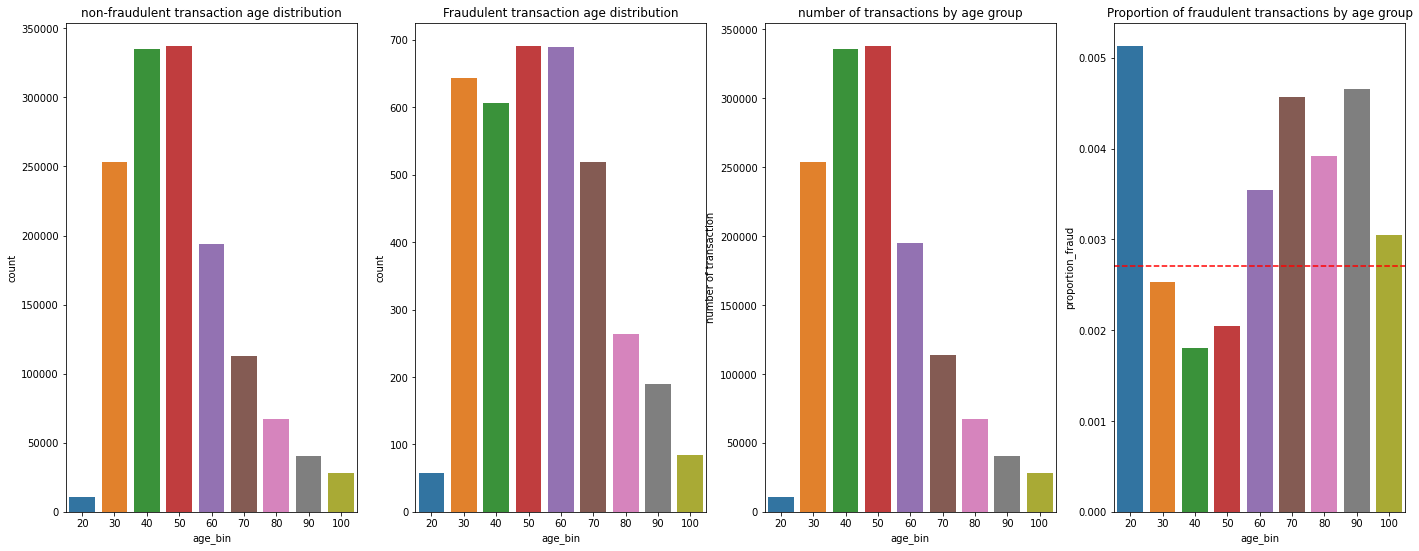

In [34]:
fig,ax = plt.subplots(1,4,figsize = (24,9))
mask = df['is_fraud'] == 0
sns.countplot(df[mask]['age_bin'] , ax = ax[0] , dodge = False)
ax[0].set_title('non-fraudulent transaction age distribution')
mask = df['is_fraud'] == 1
sns.countplot(df[mask]['age_bin'] ,ax = ax[1] , dodge = False)
ax[1].set_title('Fraudulent transaction age distribution')
sns.barplot(data = age_exp, y = 'num_of_trans_x' , x = 'age_bin' , ax = ax[2])
ax[2].set_title('number of transactions by age group')
ax[2].set_ylabel('number of transaction')
sns.barplot(data = age_exp, y = 'proportion_fraud' , x = 'age_bin' , ax = ax[3])
ax[3].set_title('Proportion of fraudulent transactions by age group')
ax[3].axhline(y=df['is_fraud'].mean(), color='r', linestyle ="--")

Proportion of fraudulent transactions differs slightly between each age group. Seems like people between the age of 20 to 50 are the slightl less likely to be victim of fraud.

In [35]:
temp_1 = df['trans_month'].value_counts().reset_index().rename(columns = {'index':'month','trans_month':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['trans_month'].value_counts().reset_index().rename(columns = {'index':'month','trans_month':'num_transaction'})
month_exp = temp_1.merge(temp_2, how = 'left', on = 'month')
month_exp['proportion_fraud'] = month_exp['num_transaction_y']/month_exp['num_transaction_x']

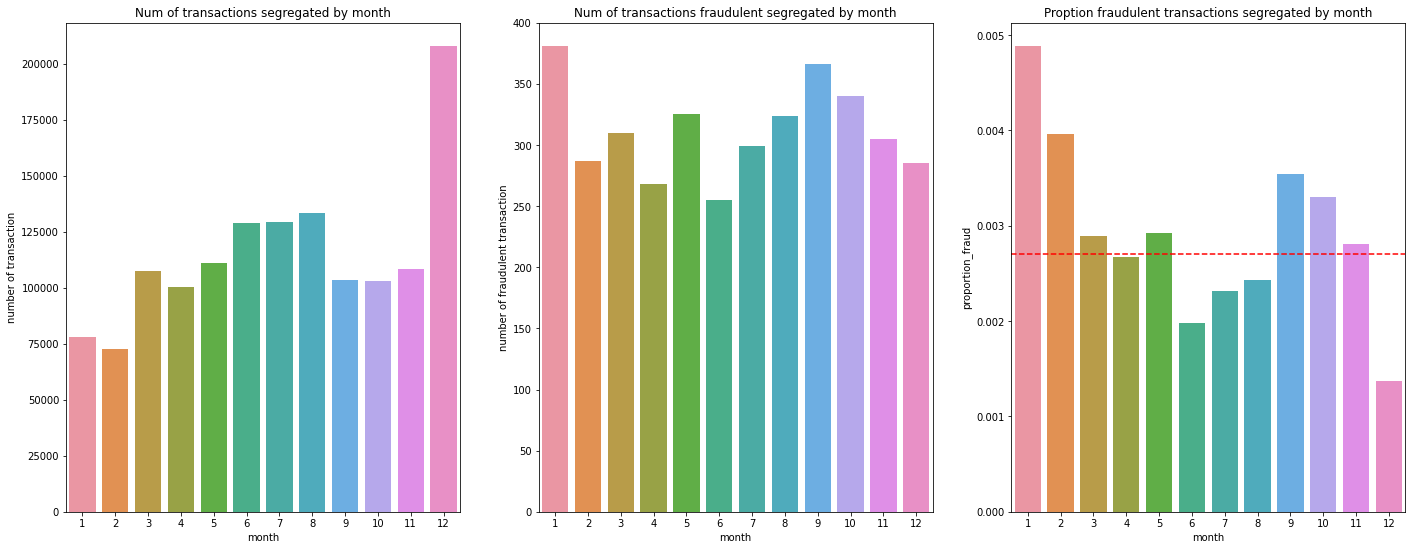

In [36]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = month_exp, y = 'num_transaction_x' , x = 'month' , ax = ax[0])
ax[0].set_ylabel('number of transaction')
ax[0].set_title('Num of transactions segregated by month')
sns.barplot(data = month_exp, y = 'num_transaction_y' , x = 'month' , ax = ax[1])
ax[1].set_ylabel('number of fraudulent transaction')
ax[1].set_title('Num of transactions fraudulent segregated by month')
sns.barplot(data = month_exp, y = 'proportion_fraud' , x = 'month' , ax = ax[2])
ax[2].set_title('Proption fraudulent transactions segregated by month')
ax[2].axhline(y=df['is_fraud'].mean(), color='r', linestyle ="--")

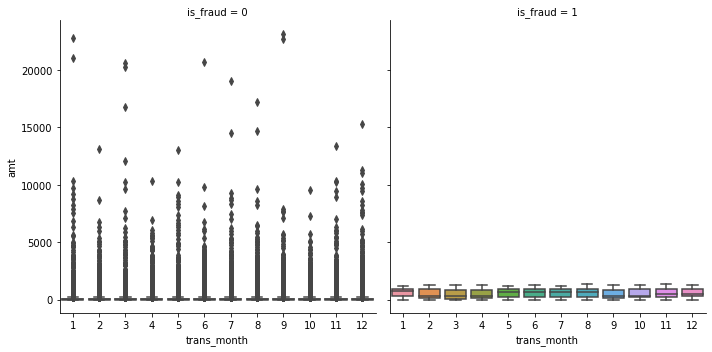

In [37]:
sns.catplot(data=df.reset_index(), 
            x ='trans_month',
            y = 'amt',
            col='is_fraud',
            kind='box', 
            col_wrap=2,
            facet_kws=dict(sharey=False)
            )

1. We can observe that there's a spike in number of transactions in the month of December, this may be due to christmas/thanksgiving spending.
2. We can observe that number of fraudulent transactions remains relatively even over the months, even though there's a tremendous spike in transaction volumne in December and a dip in Jan and Feb.

In [39]:
temp_1 = df['weekday'].value_counts().reset_index().rename(columns = {'index':'weekday','weekday':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['weekday'].value_counts().reset_index().rename(columns = {'index':'weekday','weekday':'num_transaction'})
day_exp = temp_1.merge(temp_2, how = 'left', on = 'weekday')
day_exp['proportion_fraud'] = day_exp['num_transaction_y']/day_exp['num_transaction_x']

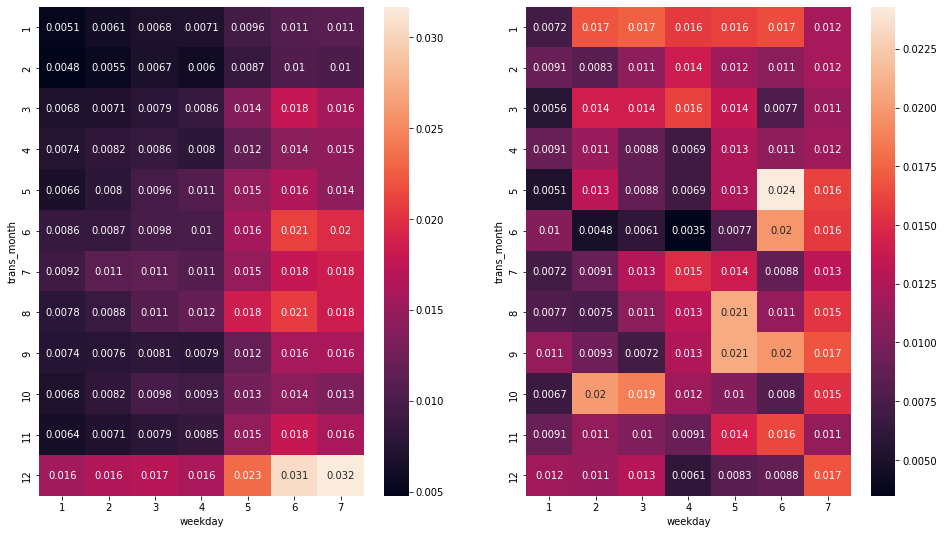

In [40]:
fig,ax = plt.subplots(1,2,figsize = (16,9))
mask = df.is_fraud == 0
sns.heatmap(pd.crosstab(df[mask].trans_month,df[mask].weekday, normalize = True) , ax = ax[0], annot = True)
mask = df.is_fraud == 1
sns.heatmap(pd.crosstab(df[mask].trans_month,df[mask].weekday, normalize = True) , ax = ax[1] , annot = True)

1. There are signifcantly more transactions occuring on weekends on every single month
2. There are signifcantly more transactions on weekdays in december, presumably the holiday season.

In [41]:
pd.crosstab([df.trans_year],[df.cc_num])

cc_num,60413431283,60426561191,60441842295,60458629379,60481563009,501811960522,501813488910,501831314213,502012457854,502015332526,502086527632,502096956318,503842480108,562635507196,564120768689,564883055019,575039333886,576029357141,583860193544,584419907905,586742935024,588050269350,589061271914,589863341162,630431947286,639038789330,639056777043,639060385544,639062841163,675924586992,675967769570,675993942605,676105735614,676110440408,676166398559,676204275215,676250172464,676260748865,676309137039,676365490801,...,4084652656498082122,4087330911939152965,4092365693469698975,4151126936401906624,4185030097518516435,4233729217952688995,4242622801283114828,4303038039637252220,4307177596616955851,4331946941798048564,4356852629290257101,4369146517177813717,4389289942931264095,4405124318184820672,4415811303391085647,4416413285035244625,4428965348077676976,4496611674634281157,4506672308334887292,4519818061165135038,4537824784826458671,4547934292239889231,4574864015084281305,4589651944452036253,4611845808478851137,4617159231447425544,4625117132257482399,4670277240347873923,4673252622880562323,4722160474324669793,4744505948561621953,4744533481377668790,4758075004748795094,4774886658140956442,4815780278230301942,4829535268718152502,4847336075974586536,4857844243189972941,4947243082542454668,4973263167465397407
trans_year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012,1128,8,1073,382,1471,1823,1124,2201,393,1764,1811,1095,0,695,763,743,1116,1108,365,2156,0,368,717,1098,1104,1102,1819,1128,1040,1098,697,375,769,375,715,384,2220,363,1852,2204,...,793,0,1140,777,1045,1137,1847,1093,393,751,698,729,389,0,10,1108,1127,713,1482,762,367,381,7,0,8,12,359,1520,724,387,374,0,1186,1097,1449,342,1079,384,0,722
2013,1080,0,1120,360,1446,1830,1108,2205,350,1869,1843,1095,12,756,723,664,1097,1110,339,2203,0,360,738,1053,1099,1089,1867,1075,1135,1075,743,371,729,363,755,361,2147,367,1833,2199,...,735,0,1105,741,1102,1101,1839,1054,330,711,752,716,390,0,0,1081,1081,706,1383,745,383,351,0,0,0,0,372,1401,777,360,336,11,1086,1111,1446,390,1087,402,13,744
2014,1137,0,1110,349,1403,1801,1053,2122,366,1851,1792,1123,0,743,698,777,1108,1090,374,2194,9,361,716,1108,1075,1055,1797,1107,1075,1105,703,349,681,393,732,377,2143,376,1797,2145,...,714,8,1063,738,1146,1065,1847,1088,396,704,768,788,335,9,0,1096,1073,756,1510,735,387,335,0,8,0,0,345,1442,730,349,389,0,1052,1088,1436,384,1118,329,0,697


1. There seems to be some credit cards that have very low number of transactions. This seems very suspicious.
2. Action : create a feature based on the number of transactions created by the card in the previous month.
3. Drop training data for Jan 2012 during training process?

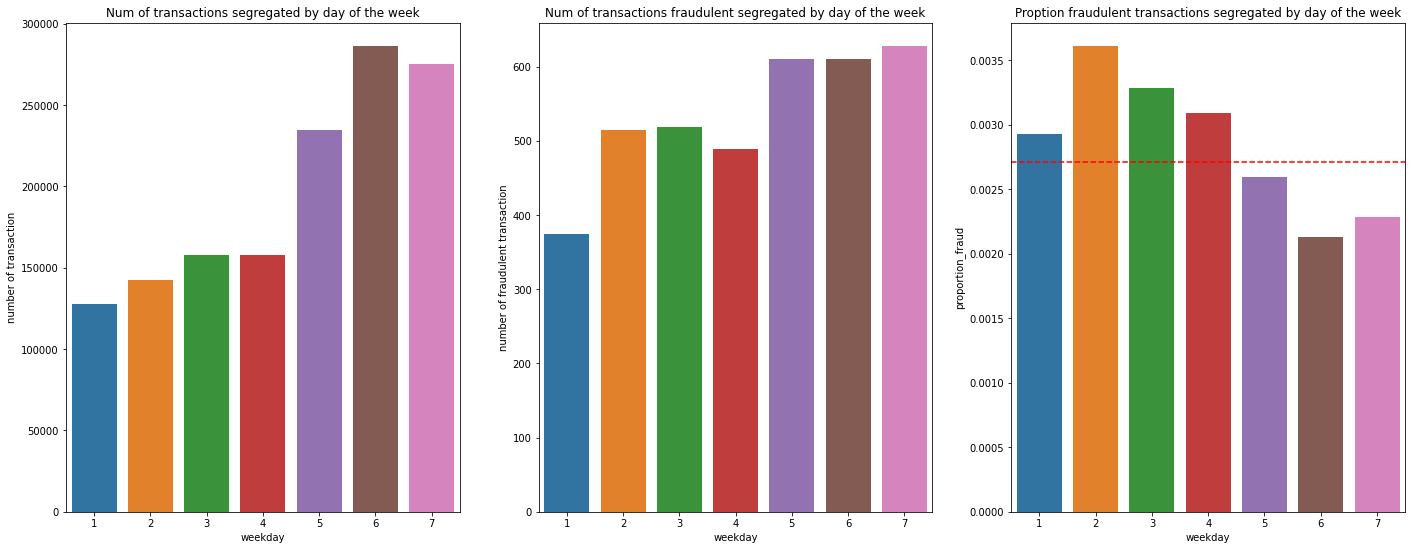

In [42]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = day_exp, y = 'num_transaction_x' , x = 'weekday' , ax = ax[0])
ax[0].set_ylabel('number of transaction')
ax[0].set_title('Num of transactions segregated by day of the week')
sns.barplot(data = day_exp, y = 'num_transaction_y' , x = 'weekday' , ax = ax[1])
ax[1].set_ylabel('number of fraudulent transaction')
ax[1].set_title('Num of transactions fraudulent segregated by day of the week')
sns.barplot(data = day_exp, y = 'proportion_fraud' , x = 'weekday' , ax = ax[2])
ax[2].set_title('Proption fraudulent transactions segregated by day of the week')
ax[2].axhline(y=df['is_fraud'].mean(), color='r', linestyle ="--")

1. Most transactions occurs over the weekends.
2. There seems to be more fraudulent transactions that occurs during the weekends
3. However proprotion of fraudulent transaction seems to be more during the weekdays.

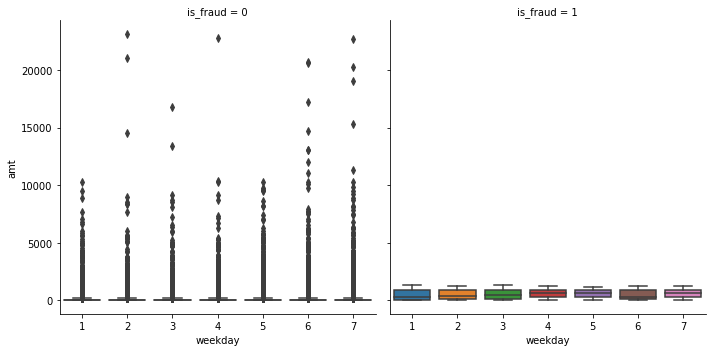

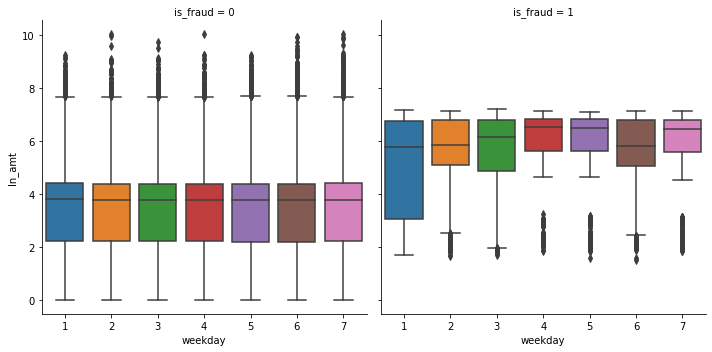

In [43]:
sns.catplot(data=df.reset_index(), 
            x ='weekday',
            y = 'amt',
            col='is_fraud',
            kind='box', 
            col_wrap=2,
            facet_kws=dict(sharey=False)
            )

sns.catplot(data=df.reset_index(), 
            x ='weekday',
            y = 'ln_amt',
            col='is_fraud',
            kind='box', 
            col_wrap=2,
            facet_kws=dict(sharey=False)
            )

1. Daily Transaction Amount seems relatively stable.
2. The median amounts tends towards the higher side.
3. Fraudulent transactions tends to be higher than regular transactions.


In [44]:
temp_1 = df['merchant'].value_counts().reset_index().rename(columns = {'index':'merchant','merchant':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['merchant'].value_counts().reset_index().rename(columns = {'index':'merchant','merchant':'num_transaction'})
merc_exp = temp_1.merge(temp_2, how = 'left', on = 'merchant')
merc_exp['proportion_fraud'] = merc_exp['num_transaction_y']/merc_exp['num_transaction_x']
merc_exp['proportion_fraud'].fillna(0,inplace = True)
merc_exp.sort_values(by = 'proportion_fraud', inplace = True)

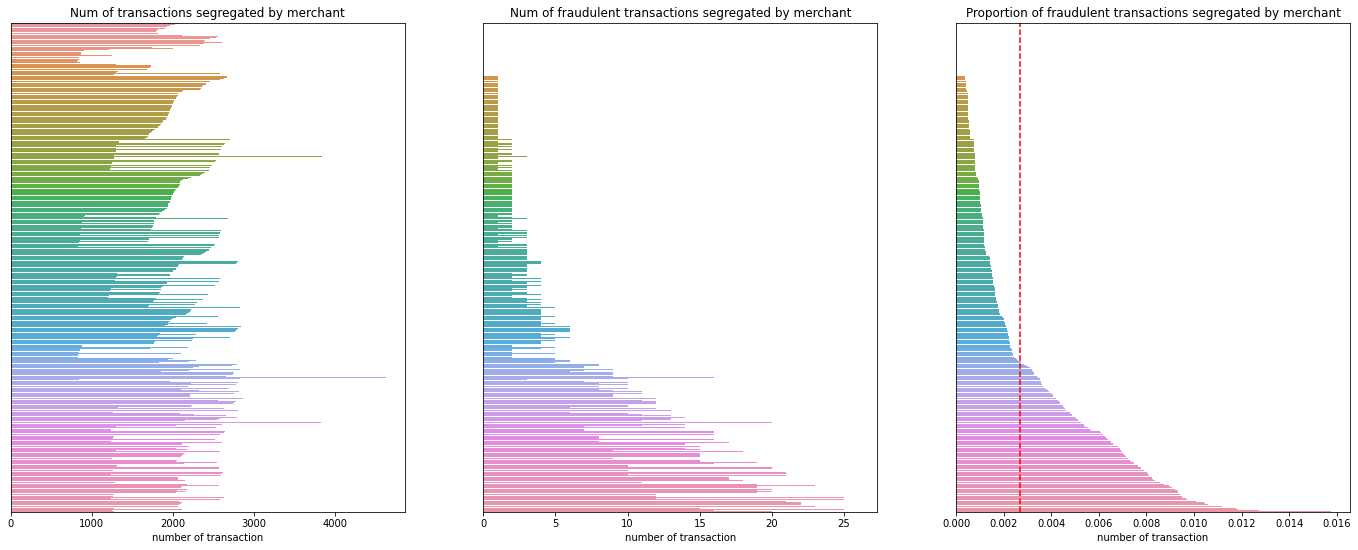

In [45]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = merc_exp, x = 'num_transaction_x' , y = 'merchant' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by merchant')
ax[0].yaxis.set_visible(False)

sns.barplot(data = merc_exp, x = 'num_transaction_y' , y = 'merchant' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by merchant')
ax[1].yaxis.set_visible(False)

sns.barplot(data = merc_exp, x = 'proportion_fraud' , y = 'merchant' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('number of transaction')
ax[2].set_title('Proportion of fraudulent transactions segregated by merchant')
ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

In [46]:
merc_agg = df.groupby('merchant').agg({'is_fraud':[np.sum,np.mean,np.std,np.shape]})

In [47]:
merc_agg.sort_values(by = ('is_fraud','mean'), ascending = False).head(10)

is_fraud                             
                                     sum      mean       std    shape
merchant                                                             
Mante Group                           20  0.015760  0.124596  (1269,)
Kerluke PLC                           16  0.012749  0.112234  (1255,)
Price Inc                             26  0.011856  0.108262  (2193,)
Gerlach Inc                           25  0.011832  0.108153  (2113,)
Hayes, Marquardt and Dibbert          15  0.011755  0.107826  (1276,)
Labadie, Treutel and Bode             24  0.011527  0.106771  (2082,)
Gottlieb, Considine and Schultz       24  0.011472  0.106518  (2092,)
Lemke-Gutmann                         23  0.011176  0.105149  (2058,)
Moore, Dibbert and Koepp              14  0.011085  0.104740  (1263,)
Flatley-Durgan                        14  0.010878  0.103769  (1287,)

1. There seems to be some merchants that are being targeted.
2. Target encoding may be necessary to simplify this feature
3. A possibe solution may be to make it an ordinal feature, base on risk category of these merchants

In [48]:
temp_1 = df['cc_num'].value_counts().reset_index().rename(columns = {'index':'cc_num','cc_num':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['cc_num'].value_counts().reset_index().rename(columns = {'index':'cc_num','cc_num':'num_transaction'})
cc_exp = temp_1.merge(temp_2, how = 'left', on = 'cc_num')
cc_exp['proportion_fraud'] = cc_exp['num_transaction_y']/cc_exp['num_transaction_x']
cc_exp.fillna(0,inplace = True)
cc_exp.sort_values(by = 'num_transaction_x', inplace = True) 

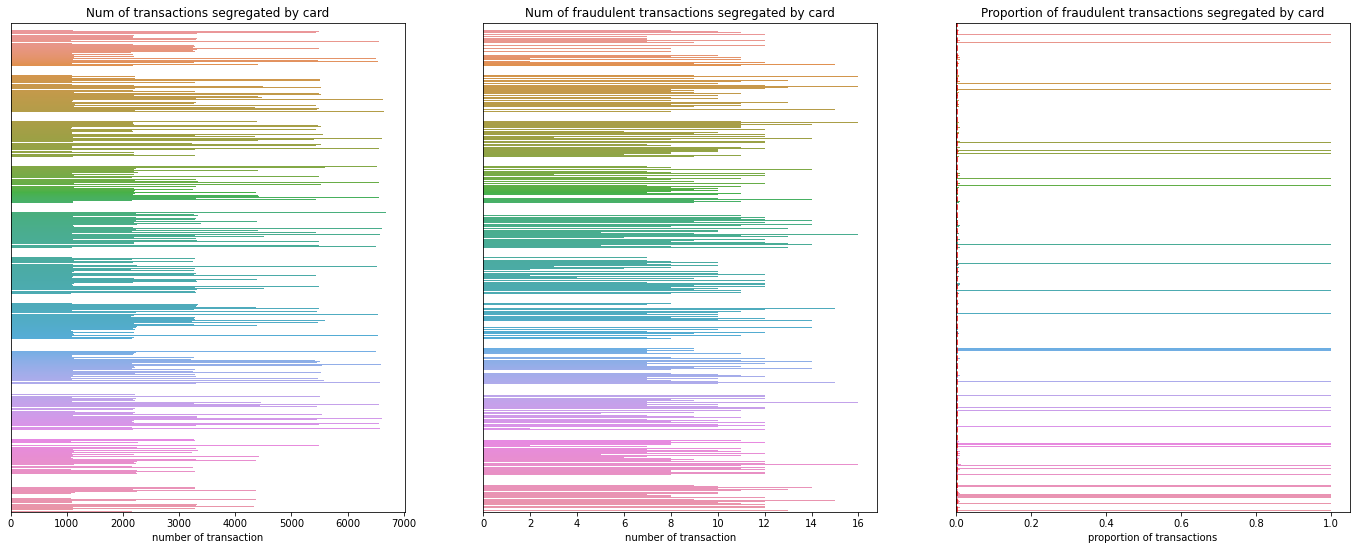

In [49]:
fig,ax = plt.subplots(1,3,figsize = (24,9)) #why is it not sorting???
sns.barplot(data = cc_exp, x = 'num_transaction_x' , y = 'cc_num' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by card')
ax[0].yaxis.set_visible(False)

sns.barplot(data = cc_exp, x = 'num_transaction_y' , y = 'cc_num' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by card')
ax[1].yaxis.set_visible(False)

sns.barplot(data = cc_exp, x = 'proportion_fraud' , y = 'cc_num' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('proportion of transactions')
ax[2].set_title('Proportion of fraudulent transactions segregated by card')
ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

In [50]:
len(cc_exp[cc_exp['proportion_fraud']==1])/len(cc_exp)

0.092

All transactions from these cards are all fraudulent, and they represent 9.2% of all credit cards.

In [51]:
temp_1 = df['category'].value_counts().reset_index().rename(columns = {'index':'category','category':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['category'].value_counts().reset_index().rename(columns = {'index':'category','category':'num_transaction'})
cat_exp = temp_1.merge(temp_2, how = 'left', on = 'category')
cat_exp['proportion_fraud'] = cat_exp['num_transaction_y']/cat_exp['num_transaction_x']

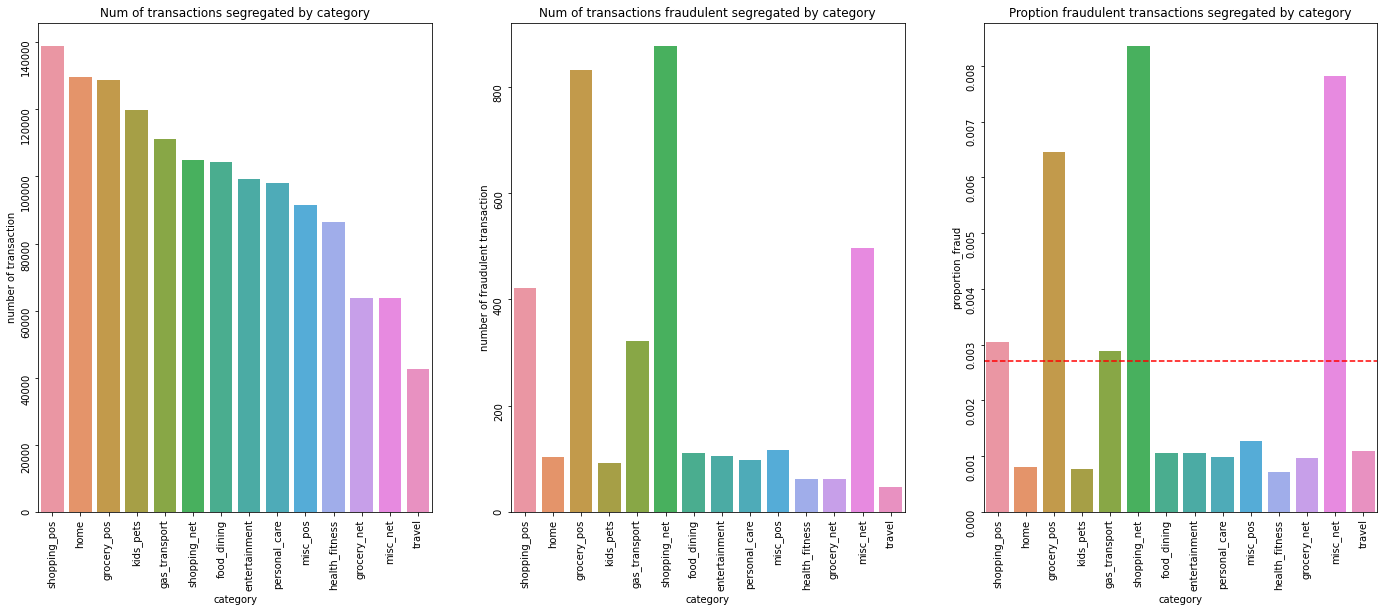

In [52]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = cat_exp, y = 'num_transaction_x' , x = 'category' , ax = ax[0])
ax[0].set_ylabel('number of transaction')
ax[0].set_title('Num of transactions segregated by category')
ax[0].tick_params(labelrotation=90)

sns.barplot(data = cat_exp, y = 'num_transaction_y' , x = 'category' , ax = ax[1])
ax[1].set_ylabel('number of fraudulent transaction')
ax[1].set_title('Num of transactions fraudulent segregated by category')
ax[1].tick_params(labelrotation=90)

sns.barplot(data = cat_exp, y = 'proportion_fraud' , x = 'category' , ax = ax[2])
ax[2].set_title('Proption fraudulent transactions segregated by category')
ax[2].axhline(y=df['is_fraud'].mean(), color='r', linestyle ="--")
ax[2].tick_params(labelrotation=90)

1.Grocery POS, Shopping POS , Shopping Net, MISC Net and Gas Transport seems to be disproportionately targeted for fraudulent activities.

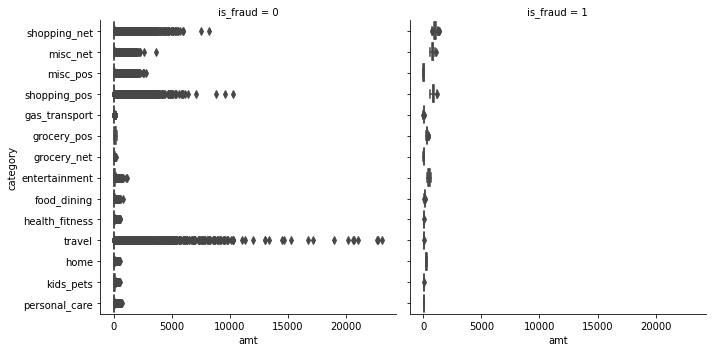

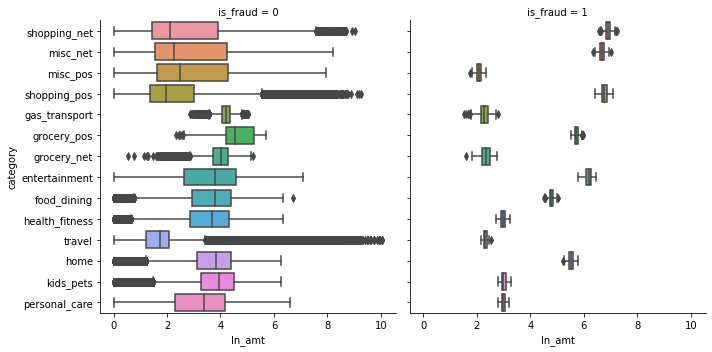

In [53]:
sns.catplot(data=df.reset_index(), 
            y ='category',
            x = 'amt',
            col='is_fraud',
            kind='box', 
            col_wrap=2,
            facet_kws=dict(sharey=False),
            orient = 'h'
            )

sns.catplot(data=df.reset_index(), 
            y ='category',
            x = 'ln_amt',
            col='is_fraud',
            kind='box', 
            col_wrap=2,
            facet_kws=dict(sharey=False),
            orient = 'h'
            )

1. Transaction amount distribution in each category tends to be quite different.
2. The variance of fraudulent transaction amount seems small.
3. Fraudulent transactions made in each category seems to be different.

In [54]:
double_cat = list(df.groupby(['merchant','category']).agg({'is_fraud':'sum'}).reset_index()['merchant'].value_counts().reset_index().head(7)['index'])
df.loc[df['merchant'].isin(double_cat)].groupby(['merchant','category']).agg({'is_fraud':['sum','count']})

is_fraud      
                                   sum count
merchant       category                     
Boyer PLC      misc_pos              1  1843
               shopping_net         16  2124
Cormier LLC    health_fitness        1  1744
               shopping_net         19  2080
Dickinson Ltd  misc_pos              1  1842
               personal_care         2  1998
Gislason Group misc_pos              1  1893
               travel                0   843
Kilback LLC    food_dining           5  2101
               grocery_pos          11  2526
Kuhn LLC       misc_net              7  1266
               shopping_pos          7  2725
Schumm PLC     health_fitness        1  1713
               shopping_net         19  2059

In [55]:
df.groupby(['merchant']).agg({'is_fraud':[np.sum,np.mean,np.std,np.shape]}).shape, df.groupby(['merchant','category']).agg({'is_fraud':[np.sum,np.mean,np.std,np.shape]}).shape
#looks like a very small number of merchants are categorised under 2 different cateogries

((693, 4), (700, 4))

In [56]:
temp_1 = df['job'].value_counts().reset_index().rename(columns = {'index':'job','job':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['job'].value_counts().reset_index().rename(columns = {'index':'job','job':'num_transaction'})
job_exp = temp_1.merge(temp_2, how = 'left', on = 'job')
job_exp['proportion_fraud'] = (job_exp['num_transaction_y'])/(job_exp['num_transaction_x'])
job_exp.fillna(0,inplace = True)
job_exp.sort_values(by = ['num_transaction_x','num_transaction_y'],ascending = [True,False], inplace = True)

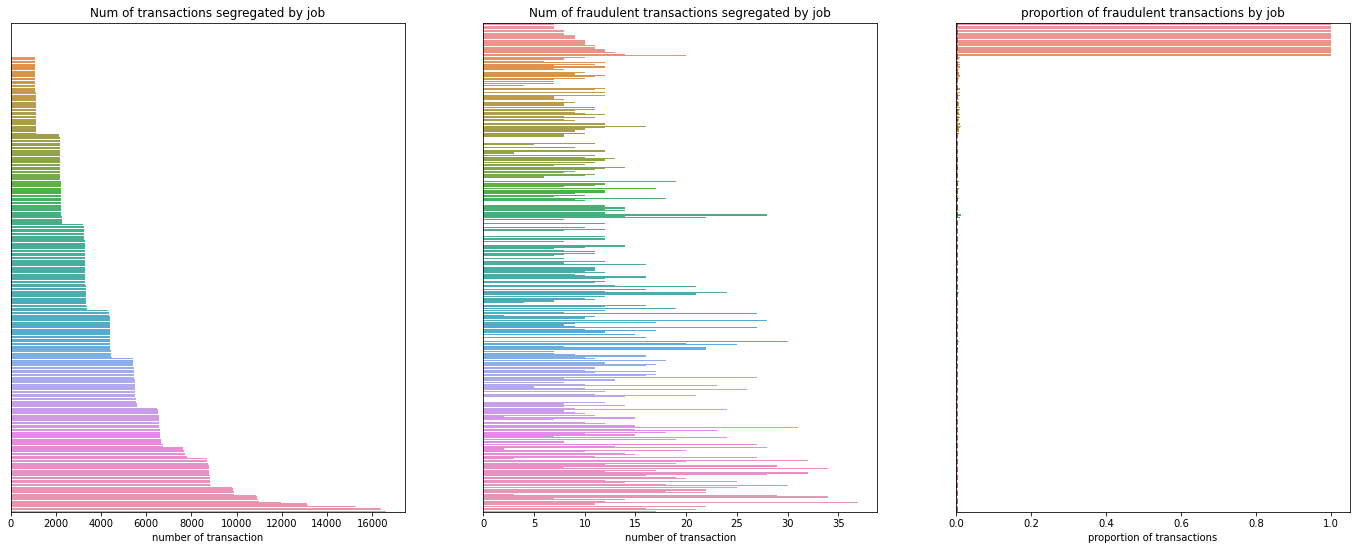

In [57]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = job_exp, x = 'num_transaction_x' , y = 'job' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by job')
ax[0].yaxis.set_visible(False)

sns.barplot(data = job_exp, x = 'num_transaction_y' , y = 'job' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by job')
ax[1].yaxis.set_visible(False)

sns.barplot(data = job_exp, x = 'proportion_fraud' , y = 'job' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('proportion of transactions')
ax[2].set_title('proportion of fraudulent transactions by job')
ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

1. There seems to be a group of job titles that are held by a small proportion of the population that seems to be targeted for fraudulent activities
2. The high cardinaity of this feature may be problematic for the model learning process, as some of the groups in the category has very small samples to learn from.
3. Proposed solution : use of target encoding to flag out these highly risky cards.

In [58]:
temp_1 = df['hour'].value_counts().reset_index().rename(columns = {'index':'hour','hour':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['hour'].value_counts().reset_index().rename(columns = {'index':'hour','hour':'num_transaction'})
time_exp = temp_1.merge(temp_2, how = 'left', on = 'hour')
time_exp['proportion_fraud'] = (time_exp['num_transaction_y'])/(time_exp['num_transaction_x'])
time_exp.fillna(0,inplace = True)
time_exp.sort_values(by = ['num_transaction_x','num_transaction_y'],ascending = [True,False], inplace = True)

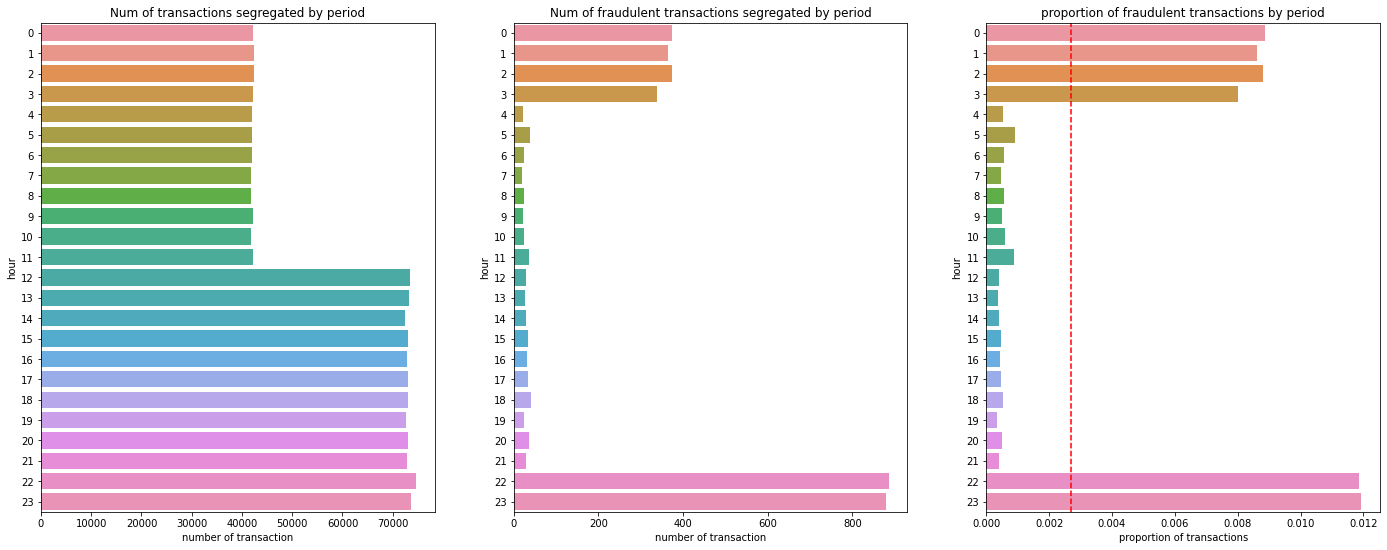

In [59]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = time_exp, x = 'num_transaction_x' , y = 'hour' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by period')
#ax[0].yaxis.set_visible(False)

sns.barplot(data = time_exp, x = 'num_transaction_y' , y = 'hour' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by period')
#ax[1].yaxis.set_visible(False)

sns.barplot(data = time_exp, x = 'proportion_fraud' , y = 'hour' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('proportion of transactions')
ax[2].set_title('proportion of fraudulent transactions by period')
#ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

In [60]:
df_test = pd.read_csv('test_ts.csv')
df_test.loc[:,'trans_date_time'] = pd.to_datetime(df_test['trans_date_time'])
df_test.sort_values(by = 'trans_date_time' , inplace = True)
df_test.set_index('trans_date_time', inplace = True)

In [61]:
df = down_cast(df)
df_test = down_cast(df_test)

In [62]:
df_test = age_bin(df_test)

1. Simplifying time feature to binary

In [63]:
def time_risk(df_):
  x = df_['hour']
  condlist = [x<4,x>21,(x>=4) & (x<=21)]              # 1 if transaction falls between 10pm and 3am (inclusive) else 0
  choicelist = [1,1,0]
  df_['time_risk'] = np.select(condlist,choicelist)

  return df_

In [64]:
df = time_risk(df)
df_test = time_risk(df_test)

In [65]:
temp_1 = df['time_risk'].value_counts().reset_index().rename(columns = {'index':'time_risk','time_risk':'num_transaction'})
mask = df['is_fraud'] == 1
temp_2 = df[mask]['time_risk'].value_counts().reset_index().rename(columns = {'index':'time_risk','time_risk':'num_transaction'})
time_exp = temp_1.merge(temp_2, how = 'left', on = 'time_risk')
time_exp['proportion_fraud'] = (time_exp['num_transaction_y'])/(time_exp['num_transaction_x'])
time_exp.fillna(0,inplace = True)
time_exp.sort_values(by = ['num_transaction_x','num_transaction_y'],ascending = [True,False], inplace = True)

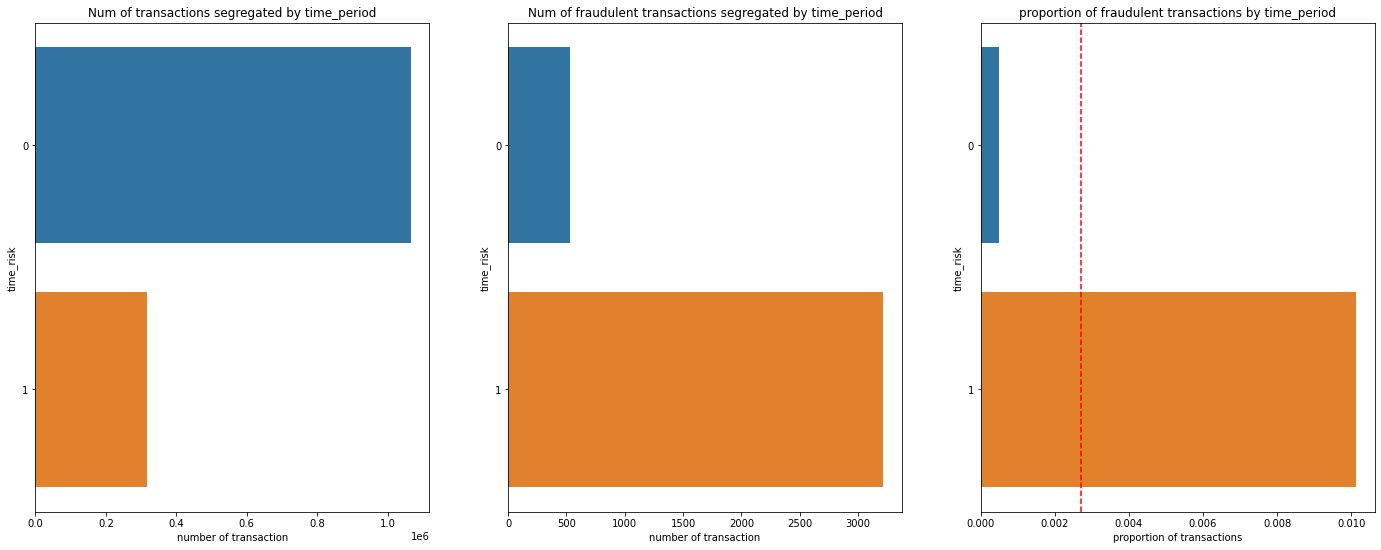

In [66]:
fig,ax = plt.subplots(1,3,figsize = (24,9))
sns.barplot(data = time_exp, x = 'num_transaction_x' , y = 'time_risk' , ax = ax[0] , orient = 'h')
ax[0].set_xlabel('number of transaction')
ax[0].set_title('Num of transactions segregated by time_period')
#ax[0].yaxis.set_visible(False)

sns.barplot(data = time_exp, x = 'num_transaction_y' , y = 'time_risk' , ax = ax[1] , orient = 'h')
ax[1].set_xlabel('number of transaction')
ax[1].set_title('Num of fraudulent transactions segregated by time_period')
#ax[1].yaxis.set_visible(False)

sns.barplot(data = time_exp, x = 'proportion_fraud' , y = 'time_risk' , ax = ax[2] , orient = 'h')
ax[2].set_xlabel('proportion of transactions')
ax[2].set_title('proportion of fraudulent transactions by time_period')
#ax[2].yaxis.set_visible(False)
ax[2].axvline(x=df['is_fraud'].mean(), color='r', linestyle ="--")

### Feature Engineering

### Feature 1 : distance from cardholder's address and merchant

In [67]:
#from math import radians, cos, sin, asin, sqrt
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [68]:
 def cardholder_to_merc_dist(df_): 
  dist = haversine(df_['lat'].values,df_['long'].values,              #compute distance between cardholder and merchant
                   df_['merch_lat'].values,df_['merch_long'].values)
  
  df_['cardholder_to_merc_dist']  = dist
  return df_

In [69]:
df = cardholder_to_merc_dist(df)
df_test = cardholder_to_merc_dist(df_test)

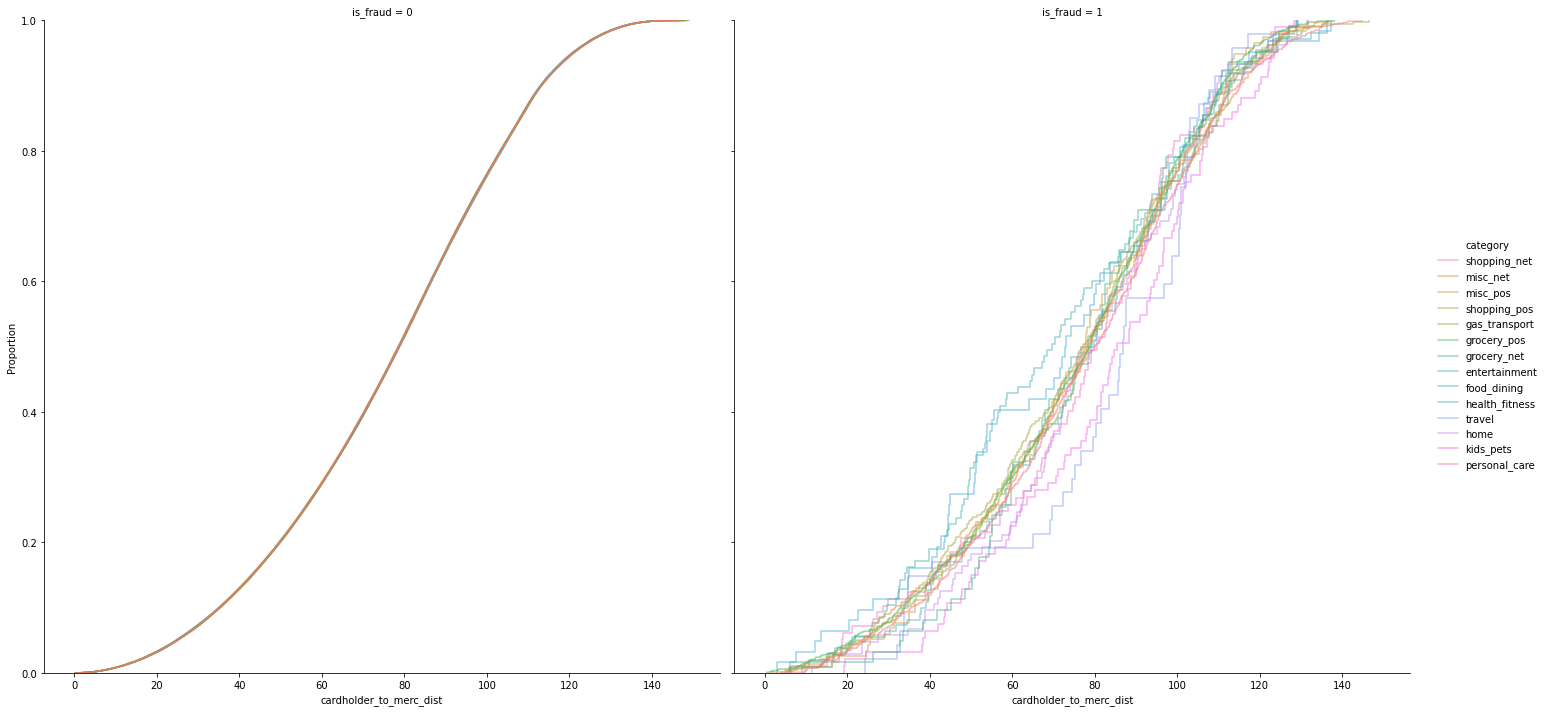

In [70]:
sns.displot(data = df.reset_index() , 
            x = 'cardholder_to_merc_dist' ,
            hue = 'category',
            col = 'is_fraud',
            alpha = 0.5 , 
            height = 10,
            aspect = 1,
            kind = 'ecdf' ) 

1. Seems like no matter which category, the distribution for 'the distance from the cardholder's registered address to the merchant' is the same.

### Feature 2 : Flagging high risk transaction values

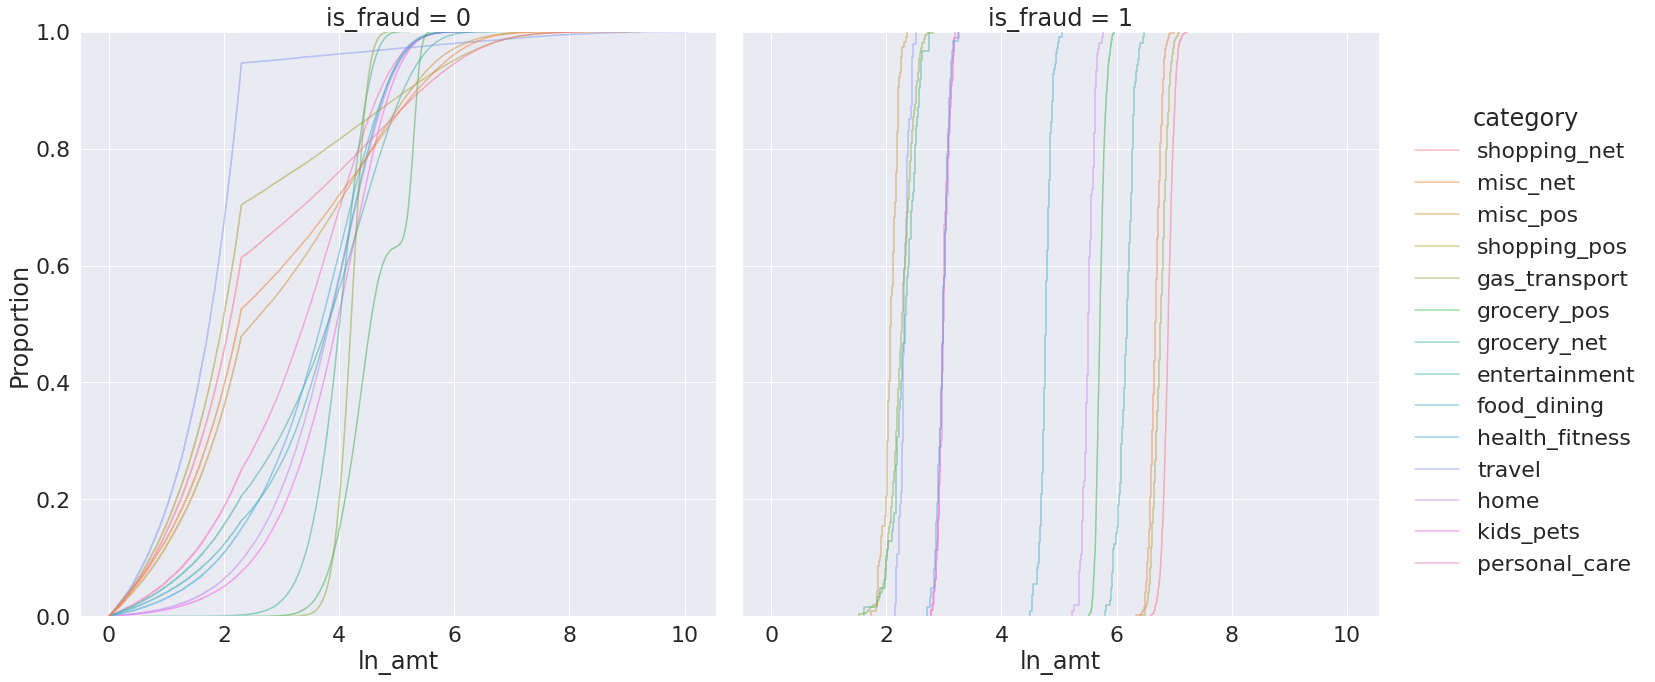

In [71]:
df['ln_amt'] = np.log(df['amt'])
sns.set(font_scale=2) 
sns.displot(data = df.reset_index() , 
            x = 'ln_amt' ,
            hue = 'category',
            col = 'is_fraud',
            alpha = 0.5 , 
            height = 10,
            aspect = 1,
            kind = 'ecdf' ) 

1.Visually we can see that the distribution of transactions for each categories are sightly different, and that each of them has a very wide variance. 

2.However, it seems like fraudulent transactions from each category has a very small variance,, with different means for each categories. Assuming that the distribution of fraudulent transactions in the near future will be similar, we can encode this information as a feature, and use it as a risk indicator.

In [72]:
def flag_cat_amt(df_train,df_test):
  df_train['ln_amt'] = np.log(df_train['amt'])
  df_test['ln_amt'] = np.log(df_test['amt'])

  temp_list = []

  mask = df_train['is_fraud']==1                                #we are assuming that fradulent transaction amounts has a specific distribution, and will continue to behave like this at least for the following year.
  cat_list = df_train['category'].unique()                      
  cat_store = []

  df_train_temp = pd.DataFrame({})
  df_test_temp = pd.DataFrame({})
  for cat in cat_list:
    mask1 = df_train['category'] == cat

    x_90 = df_train[mask&mask1]['ln_amt'].quantile(q=0.90) 
    x_25 = df_train[mask&mask1]['ln_amt'].quantile(q=0.25)

    df_train[f'{cat}_0.9q'] = x_90
    df_train[f'{cat}_0.25q'] = x_25

    df_test[f'{cat}_0.9q'] = x_90
    df_test[f'{cat}_0.25q'] = x_25


    cat_store.append(f'{cat}_0.9q')
    cat_store.append(f'{cat}_0.25q')

  for cat in cat_list:
    mask1 = df_train['category'] == cat 
    temp_train_df = df_train[mask1].copy()
    temp_train_df['flag_cat_amt'] = None
    temp_train_df['flag_cat_amt'] = np.where((temp_train_df['ln_amt']>=temp_train_df[f'{cat}_0.25q']) & (temp_train_df['ln_amt']<=temp_train_df[f'{cat}_0.9q']),
                                             1,0)
    
    mask1 = df_test['category'] == cat 
    temp_test_df = df_test[mask1].copy()
    temp_test_df['flag_cat_amt'] = None
    temp_test_df['flag_cat_amt'] = np.where((temp_test_df['ln_amt']>=temp_test_df[f'{cat}_0.25q']) & (temp_test_df['ln_amt']<=temp_test_df[f'{cat}_0.9q']),
                                             1,0)
    
    df_train_temp = pd.concat([df_train_temp,temp_train_df])
    df_test_temp = pd.concat([df_test_temp,temp_test_df])



  df_train_temp.drop(columns = cat_store , axis = 'columns' , inplace = True)
  df_test_temp.drop(columns = cat_store , axis = 'columns' , inplace = True)
  
  return df_train_temp, df_test_temp

In [73]:
df , df_test = flag_cat_amt(df,df_test)

As we have observed that there seems to be some intereaction between each category and log transform of the transaction amounts, we will create dummy variables encoded with the transaction amounts.

In [74]:
def polynomial_features(df_):                              
  df_temp = (pd.get_dummies(df_.category, prefix = 'cat')) #get dummy variables for each category
  df_temp = df_temp.mul(df_.ln_amt,axis = 0)               #encode dummy variables with transaction amount
  df_ = pd.concat([df_,df_temp], axis = 1)                
  return df_

In [75]:
df = polynomial_features(df)
df_test = polynomial_features(df_test)

#Feature 3 : 

In [76]:
def previous_transaction_distance(df_):
  if df_.index.dtype == '<M8[ns]':
    df_.reset_index(inplace = True)
  cc_list = list(df_['cc_num'].unique())
  df_temp =pd.DataFrame({})
  cc_dict = {}

  #iterate through each credit card
  for cc_num in cc_list:
    mask = df_['cc_num'] == cc_num
    temp = df_[mask].copy()
    temp['trans_shift'] = None
    temp.loc[:,'trans_shift'] = temp['trans_date_time'].diff().dt.seconds #compute the time difference between previous transaction and current transaction, convert into seconds
    temp['amt_shift'] = None
    temp.loc[:,'amt_shift'] = temp['amt'].diff() #compute the transaction amount difference between previous transaction and current transaction amount.

    temp['merch_lat_previous'] = temp['merch_lat'].shift(periods = 1)         #get the longitude and latitude of the merchant 
    temp['merch_long_previous'] = temp['merch_long'].shift(periods = 1)

    temp['distance_from_last'] = haversine(temp.merch_lat.values,             #compute the distance between current merchant and previous merchant
                                           temp.merch_long.values,
                                           temp.merch_lat_previous.values,
                                           temp.merch_long_previous.values)
    
    temp['ewm_60trans_mean'] = temp.amt.ewm(60).mean()                        #get the exponentially weighted mean for the past 60 transactions amounts
    temp['ewm_60trans_std'] = temp.amt.ewm(60).std()                          #get the exponentially weighted standard deviation past 60 transaction amounts
    cc_dict[cc_num] = temp

  df_temp = pd.concat(cc_dict.values(),ignore_index=True)
  df_temp.loc[df_temp['trans_shift'].isna(),'trans_shift'] = df_temp['trans_shift'].mean() #impute missing values with the mean amount between transactions.
  return df_temp

In [77]:
#as past data should be available at the point where predictions are to be made, I will be combining the 2015 data with 2012 - 2014 data to compute the moving window values 
df_temp = previous_transaction_distance(pd.concat([df,df_test]))
df_temp.sort_values(by = 'trans_date_time', inplace = True)
df_temp.set_index('trans_date_time', inplace = True)
df = df_temp['2012':'2014']
df_test = df_temp['2015']

df_temp = pd.DataFrame({}) 
del df_temp 

### Feature 4: Travel speed.

In [78]:
# compute the time taken to travel from merchant to merchant for each transaction

def travel_speed(df_):
  df_['travel_speed'] = None #distance between previous merchant to current merchant / time between previous and current transaction
  df_['travel_speed'] = df_.loc[:,'distance_from_last']/df_.loc[:,'trans_shift'] 
  return df_

In [79]:
df = travel_speed(df)
df_test = travel_speed(df_test)

In [80]:
df['amt_shift'].fillna(0,inplace = True)
df_test['amt_shift'].fillna(0,inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'amount difference from previous transaction')

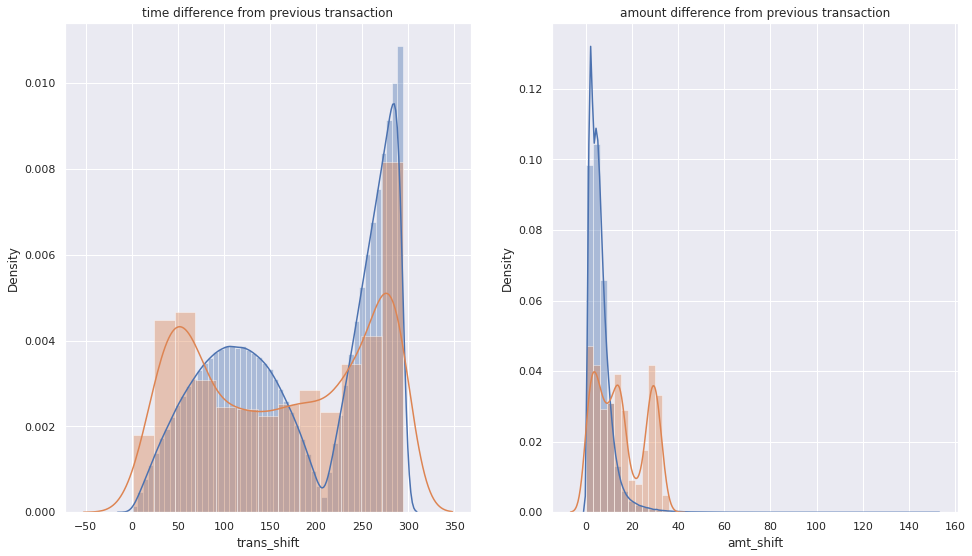

In [81]:
#df_[mask]['amt_shift'].sort_values(ascending = False)
sns.set(font_scale=1) 
fig, ax = plt.subplots(1, 2,figsize = (16,9))
mask = df['is_fraud'] == 1

sns.distplot(df[~mask]['trans_shift']**0.5, label = 'non-fraudulent transactions',kde = True , ax = ax[0])
sns.distplot(df[mask]['trans_shift']**0.5, label = 'fraudulent transactions',kde = True , ax = ax[0])
ax[0].set_title('time difference from previous transaction')

sns.distplot(df[~mask]['amt_shift']**0.5, label = 'non-fraudulent transactions',kde = True , ax = ax[1])
sns.distplot(df[mask]['amt_shift']**0.5, label = 'fraudulent transactions',kde = True , ax = ax[1])
ax[1].set_title('amount difference from previous transaction')

1. The distribution difference suggests that the fraudulent activities tend to break away from usual activities - transacted amount and time between transactions is different from the usual.

### Feature 5 : Number of transactions made by the card in the previous month

In [82]:
def get_previous_month_trans(df_):
  '''
  Generating total transactions made by the card in the previous month. This is an indicator whether this is a new card or the frequency of usuage is low.

  '''
  if df_.index.dtype == '<M8[ns]':
    df_.reset_index(inplace = True)

  df_temp = pd.DataFrame({})

  #iterate through each credit card
  for cc_num in list(df_['cc_num'].unique()):
    mask = df_['cc_num'] == cc_num
    temp_df = df_[mask].groupby(['cc_num','trans_month','trans_year']).agg({'trans_num':np.count_nonzero}).reset_index() #count number of transactions made in each month
    temp_df['previous_month_trans'] =temp_df['trans_num'].shift() # create a column with previous month transaction figures
    df_temp = pd.concat([df_temp,temp_df], ignore_index = True) #combine the information with a temporary dataframe
  

  df_temp.drop(columns = ['trans_num'] , axis = 'columns' , inplace = True) #we won't need this column anymore
  df_ = df_.merge(df_temp, how = 'left', on = ['cc_num','trans_month','trans_year']) #combine temp df with the dataframe passed in.

  return df_

In [83]:
#as past data should be available at the point where predictions are to be made, I will be combining the 2015 data with 2012 - 2014 data to compute the moving window values 
df_temp = get_previous_month_trans(pd.concat([df,df_test]))
df_temp.sort_values(by = 'trans_date_time', inplace = True)
df_temp.set_index('trans_date_time', inplace = True)
df_temp.loc[:,'previous_month_trans'].fillna(0,inplace = True) # new cards will have no transactions made in previous month; impute NAN with 0.
df = df_temp['2012':'2014']
df_test = df_temp['2015']

df_temp = pd.DataFrame({}) #
del df_temp

### Feature 6: Is weekend/holiday

In [84]:
def is_weekend(df_):
  df_['is_weekend'] = np.where(df_['weekday']>=5,1,0)               # 1 if the transaction falls on a Friday,Saturday or Sunday, else 0
  df_['is_holiday'] = np.where(df_['trans_month']==12,1,0)          # 1 if the transaction happend in December else 0
  return df_

In [85]:
df = is_weekend(df)
df_test = is_weekend(df_test)

### Feature 7: Compute average number of transactions in the previous month, depending on whether it's weekday or weekend.

In [86]:
'''
The aim of this function is to compute the average number of transactions made per day on weekends or weekday in the previous month.
The number of transactions made on each day tend to be similar across time. 
Creating this feature to pick out anomaly base on number of transactions and transaction amount.

'''
def compute_pmonth_spending_patterns(df):
  date_list = list(df['trans_date'].unique())
  cc_list   = list(df['cc_num'].unique()) 

  '''
  Weekdays here is defined as Monday to Thursdays (inclusive),
  Weekends here is defined as Friday to Sunday (inclusive)

  temp_df is created to count the number of weekends and weekdays there are in the previous month

  We seperate the count for number of transactions made in weekdays and weekends because from our analysis above, 
  that generally there are more transactions made on weekends than weekdays

  '''

  #Dataframe with number of weekends and number of weekdays

  temp_df = df.groupby(['trans_year','trans_month'])['is_fraud'].sum().reset_index() #  'is fraud' was chosen arbitrarily, any other columns in the dataframe would've sufficed, I just need a dataframe with years and months
  temp_df['string_month'] = temp_df['trans_month'].map(lambda x : '0' + str(x) if (x<10) else str(x)) #changing the format to something numpy.busday_count can handle.
  temp_df['current_month_date'] = temp_df['trans_year'].astype(str) + '-' + temp_df['string_month'] + '-01'
  temp_df['current_month_date'] = pd.to_datetime(temp_df['current_month_date']) #changing to datetime object to make use of dateoffset
  temp_df['previous_month_date'] = temp_df['current_month_date'] + pd.DateOffset(months=-1)
  temp_df['current_month_date'] = temp_df['current_month_date'].astype(str) #changing the 2 date columns to str
  temp_df['previous_month_date'] = temp_df['previous_month_date'].astype(str)
  temp_df['num_weekdays_last_month'] = np.busday_count(temp_df['previous_month_date'],temp_df['current_month_date'], weekmask = '1111000') #counting the number of weekdays
  temp_df['num_weekends_last_month'] = np.busday_count(temp_df['previous_month_date'],temp_df['current_month_date'], weekmask = '0000111') #counting the number of weekends
  temp_df.drop(columns = ['is_fraud','string_month'], axis = 'columns' , inplace = True)

  '''
  The aim of df_temp is to compute the number of total transactions that occured in the previous month for each credit card, 
  this number is segregated based on weekdays and weekends.

  We then compute the number of total number of weekend/weekday transactions that occured in the previous month
  '''

  df_temp =pd.DataFrame({})
  df_trans = pd.DataFrame({})
  trans_dict = {}
  trans_amt = {}

  
  for cc_num in cc_list: #iterate through every single credit card
    mask = df['cc_num']==cc_num
    test = df[mask][['cc_num','trans_year','trans_month','is_weekend']].value_counts().reset_index().rename(columns = {0:'monthly_total_transactions'}) #get number of transactions total transactions made on weekends and weekdays on each month
    mask = test['is_weekend'] == 0
    weekday_test = test[mask].sort_values(by = ['trans_year','trans_month','is_weekend']) #create a new data frame with total transactions made on weekdays each month
    weekday_test['previous_month_total_trans'] = weekday_test['monthly_total_transactions'].shift()  # create a column with the previous month's total transactions made on weekdays on each month
    mask = test['is_weekend'] == 1
    weekend_test = test[mask].sort_values(by = ['trans_year','trans_month','is_weekend']) #create a new data frame with total transactions made on weekends each month
    weekend_test['previous_month_total_trans'] = weekend_test['monthly_total_transactions'].shift() # create a column with the previous month's total transactions made on weekends on each month
    trans_dict[cc_num] = pd.concat([weekday_test,weekend_test],ignore_index = True) # combine the 2 dataframe above and store it in a dictionary
    
    mask = df['cc_num']==cc_num
    test = df[mask].groupby(['cc_num','trans_year','trans_month','is_weekend']).agg({'amt':np.sum}).reset_index().rename(columns = ({'amt':'total_transaction'})) #get total transaction amount made on weekends and weekdays on each month
    mask = test['is_weekend'] ==0 
    weekday_test = test[mask].sort_values(by = ['trans_year','trans_month','is_weekend']) #create a new data frame with total transaction amount made on weekdays each month
    weekday_test['previous_month_total_amt'] = weekday_test['total_transaction'].shift()  #create a column with the previous month's total transaction amounts made on weekdays on each month
    mask = test['is_weekend'] ==1 
    weekend_test = test[mask].sort_values(by = ['trans_year','trans_month','is_weekend']) #create a new data frame with total transaction amount made on weekends each month
    weekend_test['previous_month_total_amt'] = weekend_test['total_transaction'].shift()  #create a column with the previous month's total transaction amounts made on weekends on each month
    trans_amt[cc_num] = pd.concat([weekday_test,weekend_test],ignore_index = True) # combine the 2 dataframe above and store it in a dictionary

  #df_temp contains information about number of transactions made in each month
  #df_trans contains information about total transaction amounts made in each month

  df_temp = pd.concat(trans_dict.values(),ignore_index=True) #unpack the dictionary and store it as a dataframe.
  df_trans = pd.concat(trans_amt.values(),ignore_index=True) #unpack the dictionary and store it as a dataframe.

  '''
  test_merged combines both the information and get the average number of transactions that occured on a weekday or weekend, for each credit card, in the previous month.

  '''

  # Combine the 3 dataframes into a single one 

  test_merged = df_temp.merge(temp_df, how = 'left', on = ['trans_year','trans_month'])                             
  test_merged = test_merged.merge(df_trans, how = 'left', on = ['cc_num','is_weekend','trans_year','trans_month'])

  # create a column with average number of transactions made on each weekday/weekend in previous month 
  # and a column with the average transactions amount made on each weekday/weekend in previous month
  
  test_merged['is_weekday']  = test_merged['is_weekend'].map(lambda x : 0 if x == 1 else 1)
  test_merged['avg_num_ptrans'] = ((test_merged['is_weekend']*test_merged['previous_month_total_trans'])/test_merged['num_weekends_last_month'])+\
                                  ((test_merged['is_weekday']*test_merged['previous_month_total_trans'])/test_merged['num_weekdays_last_month'])

  test_merged['avg_num_pamt'] = ((test_merged['is_weekend']*test_merged['previous_month_total_amt'])/test_merged['num_weekends_last_month'])+\
                                  ((test_merged['is_weekday']*test_merged['previous_month_total_amt'])/test_merged['num_weekdays_last_month'])


  #keep only the columns that I need.
  test_merged = test_merged[['cc_num','trans_year','trans_month','is_weekend','avg_num_ptrans','avg_num_pamt']]
  

  #if the index is a datetime type, reset index.
  if df.index.dtype == '<M8[ns]':
    df.reset_index(inplace = True)
  
  #combine the main dataframe passed in with the new columns created.
  return df.merge(test_merged, how = 'left', on = ['cc_num','trans_year','trans_month','is_weekend'])

In [87]:
#as past data should be available at the point where predictions are to be made, I will be combining the 2015 data with 2012 - 2014 data to compute the moving window values 
df_temp = compute_pmonth_spending_patterns(pd.concat([df,df_test]))
df_temp.sort_values(by = 'trans_date_time', inplace = True)
df_temp.set_index('trans_date_time', inplace = True) 
df_temp.loc[:,'avg_num_ptrans'].fillna(0,inplace = True) # new cards will have no transactions made in previous month; impute NAN with 0 , 
                                                                # we don't have information prior to 2012 either, so 2012 Jan cells will be NAN
df_temp.loc[:,'avg_num_pamt'].fillna(0,inplace = True) # new cards will have no transactions made in previous month; impute NAN with 0 , 
                                                       # we don't have information prior to 2012 either, so 2012 Jan cells will be NAN                                                                
df = df_temp['2012':'2014']
df_test = df_temp['2015']
df_temp = pd.DataFrame({})
del df_temp

In [88]:
def get_transaction_number(df_):
  df_['daily_cum_sum']=df_.groupby(['cc_num','trans_date'])['amt'].cumsum()      #create a column with the cumulative sum of amt spent on the card for each day for each credit card
  df_['daily_trans_count']=df_.groupby(['cc_num','trans_date']).cumcount()+1     #create a column with the transaction number count for each day for each credit card
  return df_

In [89]:
df = get_transaction_number(df)
df_test = get_transaction_number(df_test)

In [90]:
del_columns = ['gender','lat','long','city_pop','trans_num','unix_time','dob','merch_lat','merch_long','amt_shift','merch_lat_previous','merch_long_previous','distance_from_last']

In [91]:
df.drop(columns = del_columns , inplace = True)
df_test.drop(columns = del_columns , inplace = True)

In [92]:
df.to_csv('train_engineered.csv')
df_test.to_csv('test_engineered.csv')

In [226]:
#from google.colab import files
#files.download("train_engineered.csv")
#files.download("test_engineered.csv")